In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

### Extracting information about sequence quality and enrichment

### Enrichment

+ Often want to compare two datasets (tissue 1 vs. tissue 2; -drug vs. +drug; etc.)
+ Done by taking ratio of counts for sequences between data sets

$$f_{seq} = \frac{C_{seq}}{C_{total}}$$

The normalized frequency of a sequence $f_{seq}$ is determined by the number of counts of that sequence relative to all counts in the data set.

The enrichment of the sequence in dataset 2 vs. dataset 1 is given by:

$$E_{seq} = \frac{f_{seq,2}}{f_{seq,1}}$$

where $f_{seq,1}$ and $f_{seq,2}$ are the normalized frequencies of the sequence in dataset 1 and 2. 

### How do we decide which sequences are high enough quality to include? 

<img align="center" style="margin: auto" src="https://image.slidesharecdn.com/30-140211095152-phpapp01/95/new-generation-sequencing-technologies-an-overview-13-638.jpg" />

<img align="center" style="margin: auto" src="http://ted.bti.cornell.edu/epigenome/image/Fig6.jpg" />

<img align="center" style="margin: auto" src="http://tucf-genomics.tufts.edu/images/faq02_pic03.jpg" />

### For each cluster, you get a sequence of colors representing the sequence

+ Some bases are read well, others are ambiguous. 

<img align="center" style="margin: auto" src="http://scienceblogs.com/digitalbio/wp-content/blogs.dir/460/files/2012/04/i-9d7e5f68e44ff610ccd339081d93716a-phred_qual1.gif" />

### The "Phred" score measures confidence in the base "call":

$$Q = -10log_{10}(p)$$

where $p$ is the probability that the call is **wrong**.

+ Create a plot of Q vs. p.  Is a high "Q" good or bad?

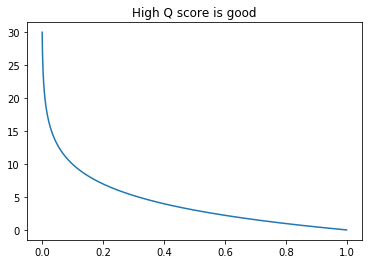

In [3]:
p = np.arange(0.001,1,0.001)
plt.plot(p,-10*np.log10(p))
plt.title("High Q score is good")

#### Phred scores are encoded in last line:

```
@SRR001666.1 071112_SLXA-EAS1_s_7:5:1:817:345 length=60
GGGTGATGGCCGCTGCCGATGGCGTCAAATCCCACCAAGTTACCCTTAACAACTTAAGGG
+SRR001666.1 071112_SLXA-EAS1_s_7:5:1:817:345 length=60
IIIIIIIIIIIIIIIIIIIIIIIIIIIIII9IG9ICIIIIIIIIIIIIIIIIIIIIDIII
```

### Encoding goes like

|Letter | ASCII | $Q$ | $p$     |
|:-----:|:-----:|:---:| -------:|
|  `!`  | 33    | 0   | 1.00000 |
|  `"`  | 34    | 1   | 0.79433 |
|  `#`  | 35    | 2   | 0.63096 |
|  ...  | ...   | ... | ...     |
|  `J`  | 74    | 41  | 0.00008 |
|  `K`  | 75    | 42  | 0.00006 |

### python `chr` command converts integer ASCII to character

In [6]:
print(chr(33))
print(chr(34))
print(chr(35))
print("...")
print(chr(74))
print(chr(75))

!
"
#
...
J
K


### Can create dictionary that converts letters to quality scores

In [8]:
Q_dict = {}
p_dict = {}
for i in range(33,76):
    Q_dict[chr(i)] = i-33
    p_dict[chr(i)] = 10**(-(Q_dict[chr(i)])/10.)
    
p_dict["K"]

6.309573444801929e-05

### Example

$$p_{correct} = \prod_{i=1}^{L} (1-p_{incorrect})$$

where $i$ indexes along sequence and $L$ is sequence length.

In [9]:
qual_string = "IIIIIIIIIIIIIIIIIIIIIIIIIIIIII9IG9ICIIIIIIIIIIIIIIIIIIIIDIII"

p_correct = 1.0
for q in qual_string:
    p_correct = p_correct*(1-p_dict[q])

print(p_correct)

0.9857512130454114


### Modify this code to pull out the $p_{correct}$ each the sequence

In [ ]:
import gzip

get_line = False
seqs = {}
with gzip.open("files/example.fastq.gz") as f:
    for l in f:
        l_ascii = l.decode("ascii")
        if l_ascii[0] == "@":
            get_line = True
            continue
        if get_line:
            try:
                seqs[l_ascii.strip()] += 1
            except KeyError:
                seqs[l_ascii.strip()] = 1
            get_line = False

### Does sequence quality vary along the length of your reads?

(0, 1)

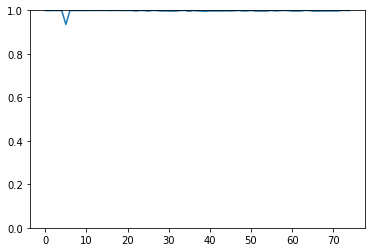

In [25]:
import gzip

Q_dict = {}
p_dict = {}
for i in range(33,76):
    Q_dict[chr(i)] = i-33
    p_dict[chr(i)] = 10**(-(Q_dict[chr(i)])/10.)

def prob_correct(qual_string):

    p_correct = 1.0
    out = []
    for q in qual_string:
        p_correct = p_correct*(1-p_dict[q])
        out.append(1-p_dict[q])
    
    return out, p_correct

get_line = 100
seqs = {}
x = np.zeros(75,dtype=float)
j = 0
with gzip.open("files/example.fastq.gz") as f:
    for l in f:
        l_ascii = l.decode("ascii")
        if l_ascii[0] == "@":
            get_line = 0
            j += 1
            continue
        if get_line == 1:
            try:
                seqs[l_ascii.strip()] += 1
            except KeyError:
                seqs[l_ascii.strip()] = 1
            get_line += 1
        elif get_line == 2:                
            out, p = prob_correct(l_ascii.strip())
            x += np.array(out)
            #plt.plot(out)
            get_line = 100
            
        else:
            get_line += 1
            
plt.plot(x/j)
plt.ylim(0,1)